## Trapezoid 45mph

In [1]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

h = 0.75
ks, kv, ka = 8, 2, 0.1

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 0.0166666666666667
#dt = 0.04
duration = 1200  #2000
m2m = 1/2.2369
v0 = 45*m2m*np.ones(4300)
#v0 = 28*m2m*np.ones(4300)
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))
    
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*3))
########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2, N_lane_3 = 10, 10, 5, 1

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3

lead_v = v0
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)*0.8

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)*1
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
vel_ego = np.zeros((max_iter+1,))
acc_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))

def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

#SS
s0=2.5
a0=1
b0=2
T=2.6
sigma=4
Kf=1
Kg=0

length = 5
spd = lead_v[0]
v0 = 33
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma)
v_len = 5

# 30mph SU
#h = 2
#ks, kv, ka = 0.3, 0.1, 0.1

# 50mph SU
h = 1.5
ks, kv, ka = 0.2, 0.1, 0.4

# SS
h = 1.75
ks, kv, ka = 1.7, 1.5, 0.5

dis = spd*h + 4
#dis = 45
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(spd), departLane = str(2), typeID="passenger")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]

y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)


X_offset, Y_offset = 814.72, 0.55
traci.simulationStep()

def dis_ego(vID_tmp):
    posi = traci.vehicle.getPosition(vID_tmp)
    dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
    return dis
    
while step<=max_iter:

    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    #traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    #pint(eLanePos)
    pos_ego[step] = eLanePos
    #vel_ego[step] = np.sqrt(vx**2+vy**2)
    vel_ego[step] = vx
    if step==0:
        acc_ego[step] = 0
    else:
        acc_ego[step] = (vel_ego[step]-vel_ego[step-1])/dt

    eLanePos = traci.vehicle.getLanePosition('ego')

    if step==0:
        #eLanePos = 10
        for i in range(N_VEHICLES):
            if i < N_lane_0:
                position[0, i] = eLanePos + (N_lane_0-i)*dis + 5 - dis*N_lane_0//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(0), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            elif i >= N_lane_0 and i < N_lane_0 + N_lane_1:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1-i)*dis + 2 - dis*N_lane_1//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(1), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            elif i >= N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis + 8
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
                
            else:
                position[0, i] = eLanePos - dis - 5
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            traci.gui.trackVehicle("View #0", "%d" % i)
            traci.gui.setZoom("View #0", 3000)
            
    elif step>=1:
        if True:
            for i in range(N_VEHICLES):
                if i == 0 or i == N_lane_0 or i == N_lane_0+N_lane_1:                  
                    accel[step,i] = lead_a[step//1]
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    if i == 0:
                        lane_idx = 0
                    elif i == N_lane_0:
                        lane_idx = 1
                    elif i == N_lane_0+N_lane_1:
                        lane_idx = 2
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    if lead_a[step//1]< -0.2:
                        traci.vehicle.setSignals("%d" % i, 3)
                    else:
                        traci.vehicle.setSignals("%d" % i, 0)
                        
                else:
                    if i < N_lane_0:
                        #space = traci.vehicle.getLanePosition("v.%d" % (i-1)) - traci.vehicle.getLanePosition("v.%d" % i)
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        #v = traci.vehicle.getSpeed("v.%d" % i)
                        v = speed[step-1,i]
                        #rel_v = traci.vehicle.getSpeed("v.%d" % (i-1)) - traci.vehicle.getSpeed("v.%d" % i)
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        #rel_acc = traci.vehicle.getAcceleration("v.%d" % (i-1))- traci.vehicle.getAcceleration("v.%d" % i)
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 0
                    elif i > N_lane_0 and i < N_lane_0 + N_lane_1:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 1
                    elif i > N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 2
                    else:
                        space = pos_ego[step-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = vel_ego[step-1] - speed[step-1,i]
                        rel_acc = acc_ego[step-1] - accel[step-1,i]
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        lane_idx = 2
                    
                    if i== N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3 - 1 and space < (speed[step-1,i]**2 - vel_ego[step-1]**2)/(2*8):
                        acceleration = -8
                    elif space < (speed[step-1,i]**2 - speed[step-1,i-1]**2)/(2*8):
                        acceleration = -8
                    accel[step,i] = acceleration
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    #traci.vehicle.setSpeed("%d" % i, speed[step,i] + acceleration*dt)
                    drag_decel = -0.25   #0.12 + (0.25*(speed[step,i] + acceleration*dt)**2)/1750
                    if acceleration < drag_decel:
                        light[step,i] = 3
                        traci.vehicle.setSignals("%d" % i, 0)
                    else:
                        light[step,i] = 0                            
                        traci.vehicle.setSignals("%d" % i, 0)
    

    #print(traci.vehicle.getPosition('ego'))
    #print(traci.vehicle.getLanePosition('ego'))
    #print(traci.vehicle.getSpeed('11'), traci.vehicle.getAcceleration('11'))
    Message=''
    Message =  "0" + "," + "0" + "," + str(step)+ "," + Message
    for k in range(N_VEHICLES):
        vID = str(k)
        
        Position = traci.vehicle.getPosition(vID)
        sig = light[step,k]      #sig = traci.vehicle.getSignals(vID)
        vel = speed[step,k] #traci.vehicle.getSpeed(vID)

        #if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
        #        continue
        Message += str(vID)+","

        #xx = "{0:.3f}".format(position[0]-x) 
        xx = "{0:.3f}".format(Position[0]-X_offset) 

        #yy = "{0:.3f}".format(position[1]-y) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 

        Message += xx + "," + yy +","
        #print(vID,Position[0],Position[1])
        #print(vID,xx,yy)
        angle = traci.vehicle.getAngle(vID)
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","
        
        Message +=  str(sig) + "," + str(vel) + ","

    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))

    step += 1

    #for i in range(N_VEHICLES):
    #    position[step,i] = traci.vehicle.getLanePosition("%d" % i)
    #    speed[step,i] = traci.vehicle.getSpeed("%d" % i)
    #    accel[step,i] = traci.vehicle.getAcceleration("%d" % i)
        #light[step,i] = traci.vehicle.getSignals("%d" % i)
    #print(speed[step-1,11], accel[step-1,11])        

    #plt.plot(speed[max(0,step-1000):step,N_lane_0 + N_lane_1])
    #print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
    traci.simulationStep()
    if step >= max_iter-1:
        np.savetxt('./run_pos_trap_45mph_su.txt', position)
        np.savetxt('./run_vel_trap_45mph_su.txt', speed)
        np.savetxt('./run_accel_trap_45mph_su.txt', accel)
        np.savetxt('./run_pos_trap_45mph_su_ego.txt', pos_ego)
        np.savetxt('./run_vel_trap_45mph_su_ego.txt', vel_ego)
        np.savetxt('./run_acc_trap_45mph_su_ego.txt', acc_ego)
        break

traci.close()

KeyboardInterrupt: 

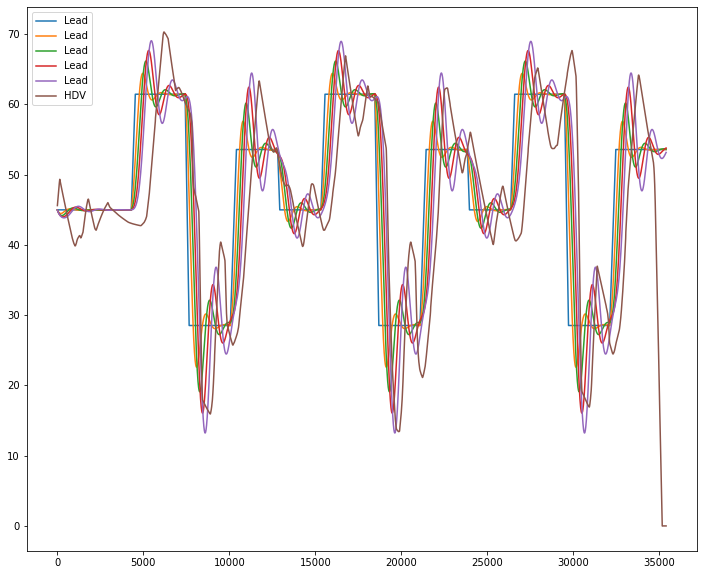

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.plot((speed[3:step//1,N_lane_0+N_lane_1:N_lane_0+N_lane_1+N_lane_2])/m2m, label='Lead')
#plt.plot((speed[3:step//1,N_lane_0+N_lane_1+1])/m2m, label='Mid')
plt.plot(vel_ego[3:step//1]/m2m, label='HDV')
plt.legend()

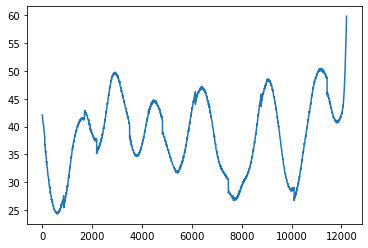

In [3]:
plt.plot(position[3:step//1,N_lane_0+N_lane_1+1] - pos_ego[3:step//1])

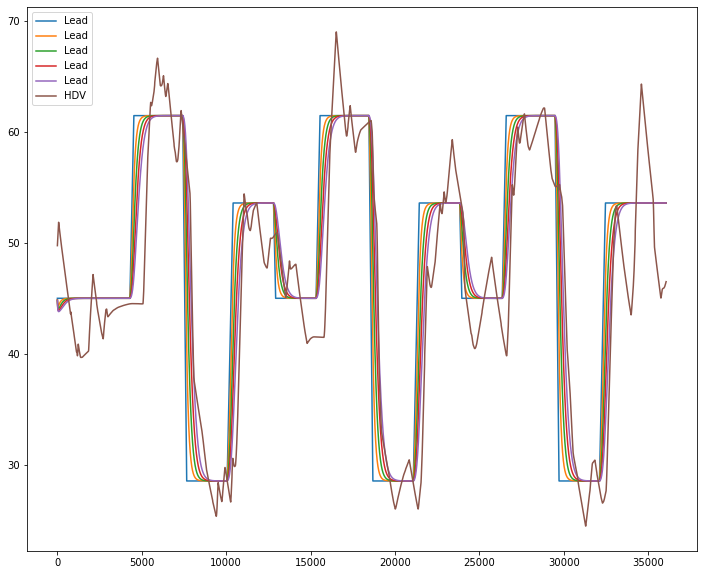

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.plot((speed[3:step//1,N_lane_0+N_lane_1:N_lane_0+N_lane_1+N_lane_2])/m2m, label='Lead')
#plt.plot((speed[3:step//1,N_lane_0+N_lane_1+1])/m2m, label='Mid')
plt.plot(vel_ego[3:step//1]/m2m, label='HDV')
plt.legend()

C:\Users\ACTLab\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ACTLab\miniconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


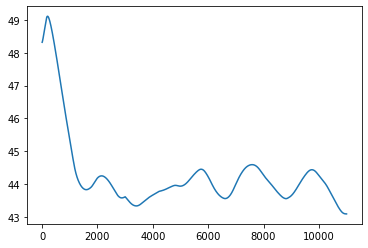

In [14]:
window = 3000
rolling_v = np.zeros(11000)
for i in range(11000):
    rolling_v[i] = np.mean(vel_ego[max(0,i-window):i])
plt.plot(rolling_v/m2m)

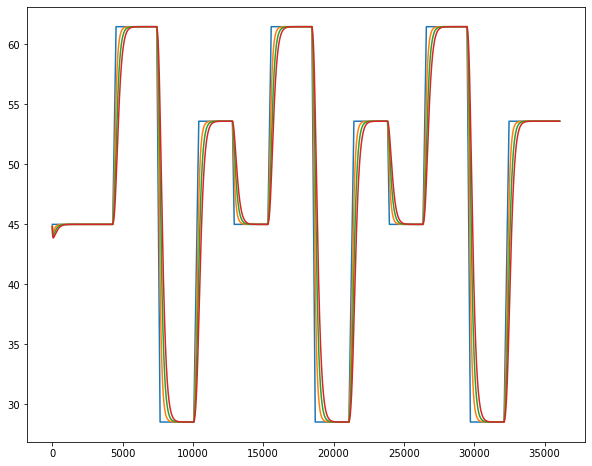

In [3]:
plt.figure(figsize=(10,8))
plt.plot((speed[3:step//1,0:4])/m2m, label='Lead')
#plt.plot((speed[3:step//1,0:])/m2m, label='Mid')
#plt.plot(vel_ego[3:step//1]/m2m, label='HDV')

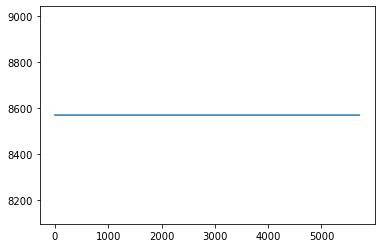

In [4]:
plt.plot(pos_ego[3:step//1])

## Trapezoid 28mph

In [1]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

h = 0.75
ks, kv, ka = 8, 2, 0.1

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 0.0166666666666667
#dt = 0.04
duration = 1200
m2m = 1/2.2369
#v0 = 45*m2m*np.ones(4300)
v0 = 28*m2m*np.ones(4300)
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(120):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))
    
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2+500))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*3))
########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2, N_lane_3 = 10, 10, 2, 1

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3

lead_v = v0
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)*1
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
vel_ego = np.zeros((max_iter+1,))
acc_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))

def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

#SS
s0=2.5
a0=1
b0=2
T=2.6
sigma=4
Kf=1
Kg=0

length = 5
spd = lead_v[0]
v0 = 33
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma)
v_len = 5

# 30mph SU
#h = 2
#ks, kv, ka = 0.3, 0.1, 0.1

# 50mph SU
h = 1.5
ks, kv, ka = 0.2, 0.1, 0.4

# SS
#h = 1
#ks, kv, ka = 2, 2, 1

dis = spd*h + 4
#dis = 45
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(spd), departLane = str(2), typeID="passenger")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]

y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)


X_offset, Y_offset = 814.72, 0.55
traci.simulationStep()

def dis_ego(vID_tmp):
    posi = traci.vehicle.getPosition(vID_tmp)
    dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
    return dis
    
while step<=max_iter:

    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    #traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    #pint(eLanePos)
    pos_ego[step] = eLanePos
    #vel_ego[step] = np.sqrt(vx**2+vy**2)
    vel_ego[step] = vx
    if step==0:
        acc_ego[step] = 0
    else:
        acc_ego[step] = (vel_ego[step]-vel_ego[step-1])/dt

    eLanePos = traci.vehicle.getLanePosition('ego')

    if step==0:
        #eLanePos = 10
        for i in range(N_VEHICLES):
            if i < N_lane_0:
                position[0, i] = eLanePos + (N_lane_0-i)*dis + 5 - dis*N_lane_0//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(0), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            elif i >= N_lane_0 and i < N_lane_0 + N_lane_1:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1-i)*dis + 2 - dis*N_lane_1//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(1), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            elif i >= N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis + 8
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
                
            else:
                position[0, i] = eLanePos - dis - 5
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            traci.gui.trackVehicle("View #0", "%d" % i)
            traci.gui.setZoom("View #0", 3000)
            
    elif step>=1:
        if True:
            for i in range(N_VEHICLES):
                if i == 0 or i == N_lane_0 or i == N_lane_0+N_lane_1:                  
                    accel[step,i] = lead_a[step//1]
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    if i == 0:
                        lane_idx = 0
                    elif i == N_lane_0:
                        lane_idx = 1
                    elif i == N_lane_0+N_lane_1:
                        lane_idx = 2
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    if lead_a[step//1]< -0.2:
                        traci.vehicle.setSignals("%d" % i, 3)
                    else:
                        traci.vehicle.setSignals("%d" % i, 0)
                        
                else:
                    if i < N_lane_0:
                        #space = traci.vehicle.getLanePosition("v.%d" % (i-1)) - traci.vehicle.getLanePosition("v.%d" % i)
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        #v = traci.vehicle.getSpeed("v.%d" % i)
                        v = speed[step-1,i]
                        #rel_v = traci.vehicle.getSpeed("v.%d" % (i-1)) - traci.vehicle.getSpeed("v.%d" % i)
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        #rel_acc = traci.vehicle.getAcceleration("v.%d" % (i-1))- traci.vehicle.getAcceleration("v.%d" % i)
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 0
                    elif i > N_lane_0 and i < N_lane_0 + N_lane_1:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 1
                    elif i > N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 2
                    else:
                        space = pos_ego[step-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = vel_ego[step-1] - speed[step-1,i]
                        rel_acc = acc_ego[step-1] - accel[step-1,i]
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        lane_idx = 2
                    
                    if i== N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3 - 1 and space < (speed[step-1,i]**2 - vel_ego[step-1]**2)/(2*8):
                        acceleration = -8
                    elif space < (speed[step-1,i]**2 - speed[step-1,i-1]**2)/(2*8):
                        acceleration = -8
                    accel[step,i] = acceleration
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    #traci.vehicle.setSpeed("%d" % i, speed[step,i] + acceleration*dt)
                    drag_decel = -0.25   #0.12 + (0.25*(speed[step,i] + acceleration*dt)**2)/1750
                    if acceleration < drag_decel:
                        light[step,i] = 3
                        traci.vehicle.setSignals("%d" % i, 0)
                    else:
                        light[step,i] = 0                            
                        traci.vehicle.setSignals("%d" % i, 0)
    

    #print(traci.vehicle.getPosition('ego'))
    #print(traci.vehicle.getLanePosition('ego'))
    #print(traci.vehicle.getSpeed('11'), traci.vehicle.getAcceleration('11'))
    Message=''
    Message =  "0" + "," + "0" + "," + str(step)+ "," + Message
    for k in range(N_VEHICLES):
        vID = str(k)
        
        Position = traci.vehicle.getPosition(vID)
        sig = light[step,k]      #sig = traci.vehicle.getSignals(vID)
        vel = speed[step,k] #traci.vehicle.getSpeed(vID)

        #if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
        #        continue
        Message += str(vID)+","

        #xx = "{0:.3f}".format(position[0]-x) 
        xx = "{0:.3f}".format(Position[0]-X_offset) 

        #yy = "{0:.3f}".format(position[1]-y) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 

        Message += xx + "," + yy +","
        #print(vID,Position[0],Position[1])
        #print(vID,xx,yy)
        angle = traci.vehicle.getAngle(vID)
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","
        
        Message +=  str(sig) + "," + str(vel) + ","

    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))

    step += 1

    #for i in range(N_VEHICLES):
    #    position[step,i] = traci.vehicle.getLanePosition("%d" % i)
    #    speed[step,i] = traci.vehicle.getSpeed("%d" % i)
    #    accel[step,i] = traci.vehicle.getAcceleration("%d" % i)
        #light[step,i] = traci.vehicle.getSignals("%d" % i)
    #print(speed[step-1,11], accel[step-1,11])        

    #plt.plot(speed[max(0,step-1000):step,N_lane_0 + N_lane_1])
    #print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
    traci.simulationStep()
    if step >= max_iter-1:
        np.savetxt('./run_pos_trap_45mph_su.txt', position)
        np.savetxt('./run_vel_trap_45mph_su.txt', speed)
        np.savetxt('./run_accel_trap_45mph_su.txt', accel)
        np.savetxt('./run_pos_trap_45mph_su_ego.txt', pos_ego)
        np.savetxt('./run_vel_trap_45mph_su_ego.txt', vel_ego)
        np.savetxt('./run_acc_trap_45mph_su_ego.txt', acc_ego)
        break

traci.close()

KeyboardInterrupt: 

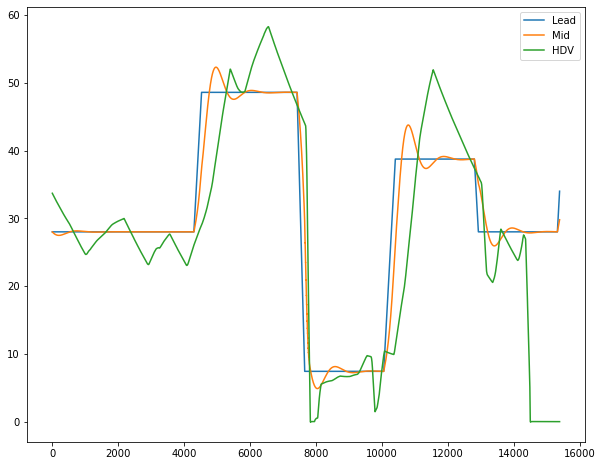

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot((speed[3:step//1,N_lane_0+N_lane_1])/m2m, label='Lead')
plt.plot((speed[3:step//1,N_lane_0+N_lane_1+1])/m2m, label='Mid')
plt.plot(vel_ego[3:step//1]/m2m, label='HDV')
plt.legend()

## NA 18mph

In [1]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

h = 0.75
ks, kv, ka = 8, 2, 0.1

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 1/60
duration = 2000
m2m = 1/2.2369
v18na = np.loadtxt('na_speed_18mph.txt')
a18na = np.diff(v18na)/0.1
a18na = np.append(0,a18na)
for i in range(len(a18na)):
    if a18na[i]>5:
        a18na[i] = 5
    elif a18na[i]<-6:
        a18na[i] = -6
        
#plt.plot(a18na)
v18new = np.zeros(a18na.shape)
v18new[0] = v18na[0]
for i in range(1,len(v18new)):
    v18new[i] = v18new[i-1] + 0.1*a18na[i]*1.3
v18new = v18new/m2m-13
for i in range(1,len(v18new)):
    if v18new[i]<0:
        v18new[i] = 0
v0 = v18new

x = np.linspace(0, v0.shape[0], v0.shape[0])
x1 = np.linspace(0, v0.shape[0], v0.shape[0]*6)
from scipy.interpolate import interp1d
vinterp = interp1d(x, v0)
v01 = vinterp(x1)
########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2, N_lane_3 = 10, 10, 2, 1

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3

lead_v = v01
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)*1
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
vel_ego = np.zeros((max_iter+1,))
acc_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))

def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

#SS
s0=2
a0=8
b0=9
T=0.8
sigma=4
Kf=1
Kg=0

#SU
s0=2.5
a0=0.67
b0=1.73
T=2.5
sigma=4
Kf=1
Kg=0

length = 5
spd = lead_v[0]
v0 = 33.3
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma) + 4
v_len = 5

# SS
#h = 1
#ks, kv, ka = 2, 2, 1

#dis = spd*h + 4
#dis = 45
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(spd), departLane = str(2), typeID="passenger")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]

y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)


X_offset, Y_offset = 814.72, 0.55
traci.simulationStep()

def dis_ego(vID_tmp):
    posi = traci.vehicle.getPosition(vID_tmp)
    dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
    return dis
    
while step<=max_iter:

    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    #traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    #pint(eLanePos)
    pos_ego[step] = eLanePos
    #vel_ego[step] = np.sqrt(vx**2+vy**2)
    vel_ego[step] = vx
    if step==0:
        acc_ego[step] = 0
    else:
        acc_ego[step] = (vel_ego[step]-vel_ego[step-1])/dt

    eLanePos = traci.vehicle.getLanePosition('ego')

    if step==0:
        #eLanePos = 10
        for i in range(N_VEHICLES):
            if i < N_lane_0:
                position[0, i] = eLanePos + (N_lane_0-i)*dis + 5 - dis*N_lane_0//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(0), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            elif i >= N_lane_0 and i < N_lane_0 + N_lane_1:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1-i)*dis + 2 - dis*N_lane_1//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(1), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            elif i >= N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis + 8
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
                
            else:
                position[0, i] = eLanePos - dis - 5
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            traci.gui.trackVehicle("View #0", "%d" % i)
            traci.gui.setZoom("View #0", 3000)
            
    elif step>=1:
        if True:
            for i in range(N_VEHICLES):
                if i == 0 or i == N_lane_0 or i == N_lane_0+N_lane_1:                  
                    accel[step,i] = lead_a[step//1]
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    if i == 0:
                        lane_idx = 0
                    elif i == N_lane_0:
                        lane_idx = 1
                    elif i == N_lane_0+N_lane_1:
                        lane_idx = 2
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    if lead_a[step//1]< -0.2:
                        traci.vehicle.setSignals("%d" % i, 3)
                    else:
                        traci.vehicle.setSignals("%d" % i, 0)
                        
                else:
                    if i < N_lane_0:
                        #space = traci.vehicle.getLanePosition("v.%d" % (i-1)) - traci.vehicle.getLanePosition("v.%d" % i)
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        #v = traci.vehicle.getSpeed("v.%d" % i)
                        v = speed[step-1,i]
                        #rel_v = traci.vehicle.getSpeed("v.%d" % (i-1)) - traci.vehicle.getSpeed("v.%d" % i)
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        #rel_acc = traci.vehicle.getAcceleration("v.%d" % (i-1))- traci.vehicle.getAcceleration("v.%d" % i)
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 0
                    elif i > N_lane_0 and i < N_lane_0 + N_lane_1:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 1
                    elif i > N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 2
                    else:
                        space = pos_ego[step-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = vel_ego[step-1] - speed[step-1,i]
                        rel_acc = acc_ego[step-1] - accel[step-1,i]
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        lane_idx = 2
                    
                    if i== N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3 - 1 and space < (speed[step-1,i]**2 - vel_ego[step-1]**2)/(2*8):
                        acceleration = -8
                    elif space < (speed[step-1,i]**2 - speed[step-1,i-1]**2)/(2*8):
                        acceleration = -8
                    accel[step,i] = acceleration
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    #traci.vehicle.setSpeed("%d" % i, speed[step,i] + acceleration*dt)
                    drag_decel = -0.25   #0.12 + (0.25*(speed[step,i] + acceleration*dt)**2)/1750
                    if acceleration < drag_decel:
                        light[step,i] = 3
                        traci.vehicle.setSignals("%d" % i, 0)
                    else:
                        light[step,i] = 0                            
                        traci.vehicle.setSignals("%d" % i, 0)
    

    #print(traci.vehicle.getPosition('ego'))
    #print(traci.vehicle.getLanePosition('ego'))
    #print(traci.vehicle.getSpeed('11'), traci.vehicle.getAcceleration('11'))
    Message=''
    Message =  "0" + "," + "0" + "," + str(step)+ "," + Message
    for k in range(N_VEHICLES):
        vID = str(k)
        
        Position = traci.vehicle.getPosition(vID)
        sig = light[step,k]      #sig = traci.vehicle.getSignals(vID)
        vel = speed[step,k] #traci.vehicle.getSpeed(vID)

        #if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
        #        continue
        Message += str(vID)+","

        #xx = "{0:.3f}".format(position[0]-x) 
        xx = "{0:.3f}".format(Position[0]-X_offset) 

        #yy = "{0:.3f}".format(position[1]-y) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 

        Message += xx + "," + yy +","
        #print(vID,Position[0],Position[1])
        #print(vID,xx,yy)
        angle = traci.vehicle.getAngle(vID)
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","
        
        Message +=  str(sig) + "," + str(vel) + ","

    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))

    step += 1

    #for i in range(N_VEHICLES):
    #    position[step,i] = traci.vehicle.getLanePosition("%d" % i)
    #    speed[step,i] = traci.vehicle.getSpeed("%d" % i)
    #    accel[step,i] = traci.vehicle.getAcceleration("%d" % i)
        #light[step,i] = traci.vehicle.getSignals("%d" % i)
    #print(speed[step-1,11], accel[step-1,11])        

    #plt.plot(speed[max(0,step-1000):step,N_lane_0 + N_lane_1])
    #print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
    traci.simulationStep()
    if step >= max_iter-1:
        np.savetxt('./run_pos_na_18mph_su.txt', position)
        np.savetxt('./run_vel_na_18mph_su.txt', speed)
        np.savetxt('./run_accel_na_18mph_su.txt', accel)
        np.savetxt('./run_pos_na_18mph_su_ego.txt', pos_ego)
        np.savetxt('./run_vel_na_18mph_su_ego.txt', vel_ego)
        np.savetxt('./run_acc_na_18mph_su_ego.txt', acc_ego)
        break

traci.close()

KeyboardInterrupt: 

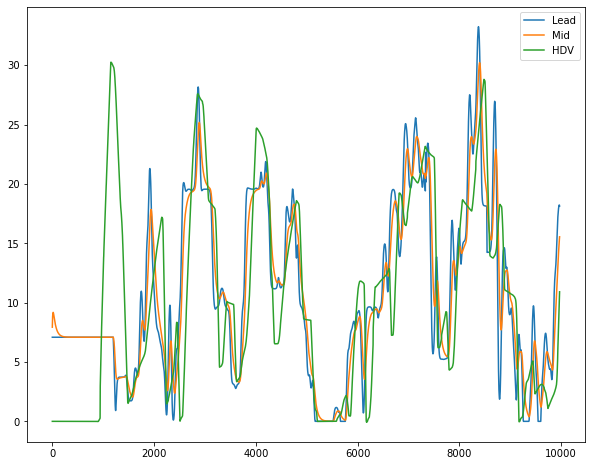

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot((speed[3:step//3,N_lane_0+N_lane_1])/m2m, label='Lead')
plt.plot((speed[3:step//3,N_lane_0+N_lane_1+1])/m2m, label='Mid')
plt.plot(vel_ego[3:step//3]/m2m, label='HDV')
plt.legend()

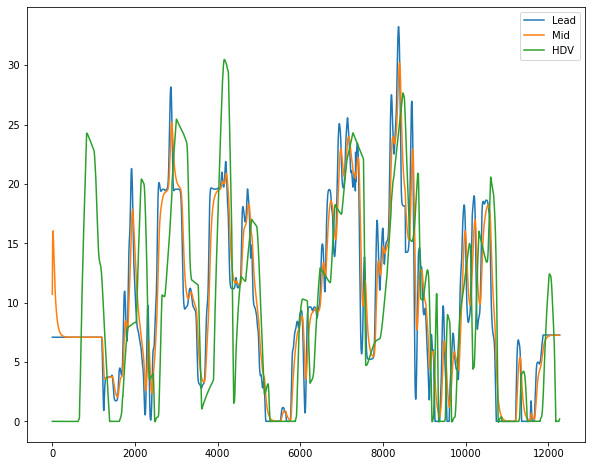

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot((speed[3:step//3,N_lane_0+N_lane_1])/m2m, label='Lead')
plt.plot((speed[3:step//3,N_lane_0+N_lane_1+1])/m2m, label='Mid')
plt.plot(vel_ego[3:step//3]/m2m, label='HDV')
plt.legend()

In [ ]:
np.savetxt('./run_pos_na_18mph_su.txt', position)
np.savetxt('./run_vel_na_18mph_su.txt', speed)
np.savetxt('./run_accel_na_18mph_su.txt', accel)
np.savetxt('./run_pos_na_18mph_su_ego.txt', pos_ego)
np.savetxt('./run_vel_na_18mph_su_ego.txt', vel_ego)
np.savetxt('./run_acc_na_18mph_su_ego.txt', acc_ego)

## NA 48mph

In [1]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

h = 0.75
ks, kv, ka = 8, 2, 0.1

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 1/60
duration = 2000
m2m = 1/2.2369
v48na = np.loadtxt('na_speed_48mph.txt')
a48na = np.diff(v48na)/0.1
a48na = np.append(0,a48na)

v48new = np.zeros(a48na.shape)
v48new[0] = v48na[0]
for i in range(1,len(v48new)):
    v48new[i] = v48new[i-1] + 0.1*a48na[i]*1
v0 = v48new
x = np.linspace(0, v0.shape[0], v0.shape[0])
x1 = np.linspace(0, v0.shape[0], v0.shape[0]*6)
from scipy.interpolate import interp1d
vinterp = interp1d(x, v0)
v01 = vinterp(x1)
########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2, N_lane_3 = 10, 10, 2, 1

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3

lead_v = v01
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)*1
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
vel_ego = np.zeros((max_iter+1,))
acc_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))

def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

#SS
s0=2
a0=8
b0=9
T=0.8
sigma=4
Kf=1
Kg=0

length = 5
spd = lead_v[0]
v0 = 33.3
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma) + 4
v_len = 5

# SS
#h = 1
#ks, kv, ka = 2, 2, 1

#dis = spd*h + 4
#dis = 45
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(spd), departLane = str(2), typeID="passenger")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]

y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)


X_offset, Y_offset = 814.72, 0.55
traci.simulationStep()

def dis_ego(vID_tmp):
    posi = traci.vehicle.getPosition(vID_tmp)
    dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
    return dis
    
while step<=max_iter:

    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    #traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    #pint(eLanePos)
    pos_ego[step] = eLanePos
    #vel_ego[step] = np.sqrt(vx**2+vy**2)
    vel_ego[step] = vx
    if step==0:
        acc_ego[step] = 0
    else:
        acc_ego[step] = (vel_ego[step]-vel_ego[step-1])/dt

    eLanePos = traci.vehicle.getLanePosition('ego')

    if step==0:
        #eLanePos = 10
        for i in range(N_VEHICLES):
            if i < N_lane_0:
                position[0, i] = eLanePos + (N_lane_0-i)*dis + 5 - dis*N_lane_0//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(0), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            elif i >= N_lane_0 and i < N_lane_0 + N_lane_1:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1-i)*dis + 2 - dis*N_lane_1//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(1), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            elif i >= N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis + 8
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
                
            else:
                position[0, i] = eLanePos - dis - 5
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            traci.gui.trackVehicle("View #0", "%d" % i)
            traci.gui.setZoom("View #0", 3000)
            
    elif step>=1:
        if True:
            for i in range(N_VEHICLES):
                if i == 0 or i == N_lane_0 or i == N_lane_0+N_lane_1:                  
                    accel[step,i] = lead_a[step//1]
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    if i == 0:
                        lane_idx = 0
                    elif i == N_lane_0:
                        lane_idx = 1
                    elif i == N_lane_0+N_lane_1:
                        lane_idx = 2
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    if lead_a[step//1]< -0.2:
                        traci.vehicle.setSignals("%d" % i, 3)
                    else:
                        traci.vehicle.setSignals("%d" % i, 0)
                        
                else:
                    if i < N_lane_0:
                        #space = traci.vehicle.getLanePosition("v.%d" % (i-1)) - traci.vehicle.getLanePosition("v.%d" % i)
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        #v = traci.vehicle.getSpeed("v.%d" % i)
                        v = speed[step-1,i]
                        #rel_v = traci.vehicle.getSpeed("v.%d" % (i-1)) - traci.vehicle.getSpeed("v.%d" % i)
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        #rel_acc = traci.vehicle.getAcceleration("v.%d" % (i-1))- traci.vehicle.getAcceleration("v.%d" % i)
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 0
                    elif i > N_lane_0 and i < N_lane_0 + N_lane_1:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 1
                    elif i > N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        #acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 2
                    else:
                        space = pos_ego[step-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = vel_ego[step-1] - speed[step-1,i]
                        rel_acc = acc_ego[step-1] - accel[step-1,i]
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        lane_idx = 2
                    
                    if i== N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3 - 1 and space < 4:
                        acceleration = -8
                    elif space < (speed[step-1,i]**2 - speed[step-1,i-1]**2)/(2*8):
                        acceleration = -8
                    accel[step,i] = acceleration
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    #traci.vehicle.setSpeed("%d" % i, speed[step,i] + acceleration*dt)
                    drag_decel = -0.25   #0.12 + (0.25*(speed[step,i] + acceleration*dt)**2)/1750
                    if acceleration < drag_decel:
                        light[step,i] = 3
                        traci.vehicle.setSignals("%d" % i, 0)
                    else:
                        light[step,i] = 0                            
                        traci.vehicle.setSignals("%d" % i, 0)
    

    #print(traci.vehicle.getPosition('ego'))
    #print(traci.vehicle.getLanePosition('ego'))
    #print(traci.vehicle.getSpeed('11'), traci.vehicle.getAcceleration('11'))
    Message=''
    Message =  "0" + "," + "0" + "," + str(step)+ "," + Message
    for k in range(N_VEHICLES):
        vID = str(k)
        
        Position = traci.vehicle.getPosition(vID)
        sig = light[step,k]      #sig = traci.vehicle.getSignals(vID)
        vel = speed[step,k] #traci.vehicle.getSpeed(vID)

        #if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
        #        continue
        Message += str(vID)+","

        #xx = "{0:.3f}".format(position[0]-x) 
        xx = "{0:.3f}".format(Position[0]-X_offset) 

        #yy = "{0:.3f}".format(position[1]-y) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 

        Message += xx + "," + yy +","
        #print(vID,Position[0],Position[1])
        #print(vID,xx,yy)
        angle = traci.vehicle.getAngle(vID)
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","
        
        Message +=  str(sig) + "," + str(vel) + ","

    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))

    step += 1

    #for i in range(N_VEHICLES):
    #    position[step,i] = traci.vehicle.getLanePosition("%d" % i)
    #    speed[step,i] = traci.vehicle.getSpeed("%d" % i)
    #    accel[step,i] = traci.vehicle.getAcceleration("%d" % i)
        #light[step,i] = traci.vehicle.getSignals("%d" % i)
    print(vy, vx)        

    #plt.plot(speed[max(0,step-1000):step,N_lane_0 + N_lane_1])
    #print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
    traci.simulationStep()
    if step >= max_iter-1:
        np.savetxt('./run_pos_na_48mph_su.txt', position)
        np.savetxt('./run_vel_na_48mph_su.txt', speed)
        np.savetxt('./run_accel_na_48mph_su.txt', accel)
        np.savetxt('./run_pos_na_48mph_su_ego.txt', pos_ego)
        np.savetxt('./run_vel_na_48mph_su_ego.txt', vel_ego)
        np.savetxt('./run_acc_na_48mph_su_ego.txt', acc_ego)
        break

traci.close()

-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0


-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0


-0.172 9.779
-0.175 9.855
-0.178 9.931
-0.181 10.007
-0.184 10.082
-0.187 10.158
-0.19 10.234
-0.193 10.31
-0.196 10.395
-0.2 10.48
-0.203 10.56
-0.205 10.617
-0.207 10.688
-0.21 10.768
-0.21 10.797
-0.214 10.9
-0.215 10.933
-0.219 11.069
-0.221 11.153
-0.223 11.219
-0.225 11.307
-0.226 11.368
-0.228 11.443
-0.23 11.517
-0.232 11.606
-0.207 10.688
-0.21 10.768
-0.21 10.797
-0.214 10.9
-0.215 10.933
-0.219 11.069
-0.221 11.153
-0.223 11.219
-0.225 11.307
-0.226 11.368
-0.228 11.443
-0.23 11.517
-0.232 11.606
-0.234 11.667
-0.236 11.741
-0.237 11.816
-0.239 11.89
-0.241 11.964
-0.242 12.039
-0.244 12.113
-0.245 12.187
-0.247 12.261
-0.248 12.336
-0.249 12.414
-0.25 12.484
-0.252 12.567
-0.234 11.667
-0.236 11.741
-0.237 11.816
-0.239 11.89
-0.241 11.964
-0.242 12.039
-0.244 12.113
-0.245 12.187
-0.247 12.261
-0.248 12.336
-0.249 12.414
-0.25 12.484
-0.252 12.567
-0.253 12.638
-0.254 12.728
-0.256 12.876
-0.257 12.956
-0.258 13.032
-0.259 13.106
-0.259 13.177
-0.259 13.246
-0.259 13.314
-

0.096 20.516
0.092 20.556
0.088 20.597
0.084 20.637
0.08 20.677
0.076 20.718
0.072 20.758
0.068 20.798
0.064 20.838
0.06 20.881
0.057 20.919
0.053 20.959
0.096 20.516
0.092 20.556
0.088 20.597
0.084 20.637
0.08 20.677
0.076 20.718
0.072 20.758
0.068 20.798
0.064 20.838
0.06 20.881
0.057 20.919
0.053 20.959
0.049 21.002
0.046 21.039
0.043 21.079
0.039 21.119
0.036 21.159
0.033 21.2
0.03 21.24
0.027 21.28
0.024 21.32
0.021 21.36
0.019 21.4
0.016 21.44
0.049 21.002
0.046 21.039
0.043 21.079
0.039 21.119
0.036 21.159
0.033 21.2
0.03 21.24
0.027 21.28
0.024 21.32
0.021 21.36
0.019 21.4
0.016 21.44
0.015 21.467
0.01 21.56
0.007 21.6
0.005 21.64
0.003 21.68
0.001 21.722
0.001 21.727
0.0 21.739
-0.004 21.841
-0.005 21.878
-0.006 21.918
-0.007 21.957
0.015 21.467
0.01 21.56
0.007 21.6
0.005 21.64
0.003 21.68
0.001 21.722
0.001 21.727
0.0 21.739
-0.004 21.841
-0.005 21.878
-0.006 21.918
-0.007 21.957
-0.008 21.971
-0.009 22.017
-0.01 22.028
-0.01 22.048
-0.011 22.059
-0.011 22.07
-0.012 22.079
-

0.085 22.8
0.085 22.814
0.085 22.828
0.085 22.843
0.085 22.856
0.084 22.871
0.084 22.875
0.083 22.9
0.082 22.914
0.081 22.928
0.08 22.942
0.079 22.957
0.085 22.8
0.085 22.814
0.085 22.828
0.085 22.843
0.085 22.856
0.084 22.871
0.084 22.875
0.083 22.9
0.082 22.914
0.081 22.928
0.08 22.942
0.079 22.957
0.078 22.971
0.076 22.986
0.075 22.999
0.073 23.014
0.071 23.028
0.069 23.042
0.065 23.07
0.063 23.084
0.06 23.099
0.058 23.112
0.055 23.127
0.078 22.971
0.076 22.986
0.075 22.999
0.073 23.014
0.071 23.028
0.069 23.042
0.065 23.07
0.063 23.084
0.06 23.099
0.058 23.112
0.055 23.127
0.053 23.141
0.051 23.155
0.048 23.169
0.046 23.184
0.043 23.198
0.041 23.211
0.038 23.226
0.036 23.239
0.034 23.253
0.031 23.268
0.03 23.272
0.026 23.296
0.023 23.31
0.053 23.141
0.051 23.155
0.048 23.169
0.046 23.184
0.043 23.198
0.041 23.211
0.038 23.226
0.036 23.239
0.034 23.253
0.031 23.268
0.03 23.272
0.026 23.296
0.023 23.31
0.021 23.323
0.019 23.337
0.016 23.352
0.014 23.365
0.012 23.38
0.009 23.394
0.007

-0.037 26.858
-0.037 26.87
-0.037 26.883
-0.037 26.895
-0.036 26.908
-0.036 26.92
-0.036 26.932
-0.036 26.945
-0.036 26.957
-0.036 26.969
-0.035 26.982
-0.035 26.994
-0.035 27.006
-0.034 27.019
-0.034 27.031
-0.033 27.043
-0.033 27.055
-0.032 27.068
-0.031 27.08
-0.03 27.092
-0.029 27.104
-0.028 27.117
-0.027 27.129
-0.026 27.141
-0.035 27.006
-0.034 27.019
-0.034 27.031
-0.033 27.043
-0.033 27.055
-0.032 27.068
-0.031 27.08
-0.03 27.092
-0.029 27.104
-0.028 27.117
-0.027 27.129
-0.026 27.141
-0.024 27.165
-0.022 27.178
-0.021 27.19
-0.019 27.202
-0.018 27.214
-0.016 27.226
-0.014 27.238
-0.013 27.251
-0.011 27.263
-0.009 27.274
-0.008 27.279
-0.005 27.299
-0.004 27.311
-0.024 27.165
-0.022 27.178
-0.021 27.19
-0.019 27.202
-0.018 27.214
-0.016 27.226
-0.014 27.238
-0.013 27.251
-0.011 27.263
-0.009 27.274
-0.008 27.279
-0.005 27.299
-0.004 27.311
-0.002 27.323
0.0 27.335
0.002 27.348
0.004 27.36
0.006 27.372
0.007 27.384
0.009 27.396
0.011 27.408
0.012 27.42
0.014 27.432
0.015 27.444


0.103 32.538
0.103 32.547
0.099 32.592
0.097 32.614
0.096 32.637
0.092 32.681
0.09 32.705
0.088 32.729
0.086 32.748
0.085 32.77
0.083 32.793
0.081 32.809
0.079 32.837
0.077 32.862
0.075 32.884
0.075 32.893
0.072 32.926
0.07 32.948
0.068 32.97
0.066 32.993
0.064 33.018
0.063 33.037
0.061 33.059
0.059 33.081
0.058 33.103
0.079 32.837
0.077 32.862
0.075 32.884
0.075 32.893
0.072 32.926
0.07 32.948
0.068 32.97
0.066 32.993
0.064 33.018
0.063 33.037
0.061 33.059
0.059 33.081
0.058 33.103
0.056 33.126
0.054 33.151
0.053 33.17
0.051 33.192
0.049 33.214
0.048 33.236
0.046 33.258
0.045 33.28
0.043 33.305
0.042 33.326
0.04 33.347
0.039 33.372
0.037 33.394
0.056 33.126
0.054 33.151
0.053 33.17
0.051 33.192
0.049 33.214
0.048 33.236
0.046 33.258
0.045 33.28
0.043 33.305
0.042 33.326
0.04 33.347
0.039 33.372
0.037 33.394
0.036 33.416
0.034 33.438
0.033 33.457
0.032 33.48
0.03 33.504
0.029 33.524
0.027 33.546
0.027 33.552
0.024 33.592
0.023 33.612
0.022 33.633
0.02 33.656
0.036 33.416
0.034 33.438
0

-0.012 39.396
-0.012 39.416
-0.013 39.434
-0.014 39.455
-0.014 39.476
-0.015 39.496
-0.016 39.508
-0.017 39.542
-0.017 39.562
-0.018 39.584
-0.019 39.604
-0.02 39.623
-0.021 39.642
-0.021 39.66
-0.022 39.677
-0.023 39.694
-0.024 39.711
-0.025 39.728
-0.026 39.745
-0.027 39.761
-0.028 39.776
-0.029 39.791
-0.03 39.807
-0.031 39.822
-0.032 39.835
-0.021 39.66
-0.022 39.677
-0.023 39.694
-0.024 39.711
-0.025 39.728
-0.026 39.745
-0.027 39.761
-0.028 39.776
-0.029 39.791
-0.03 39.807
-0.031 39.822
-0.032 39.835
-0.033 39.85
-0.034 39.864
-0.035 39.879
-0.036 39.893
-0.037 39.907
-0.038 39.92
-0.039 39.934
-0.041 39.947
-0.042 39.96
-0.043 39.973
-0.044 39.986
-0.045 39.999
-0.033 39.85
-0.034 39.864
-0.035 39.879
-0.036 39.893
-0.037 39.907
-0.038 39.92
-0.039 39.934
-0.041 39.947
-0.042 39.96
-0.043 39.973
-0.044 39.986
-0.045 39.999
-0.046 40.012
-0.047 40.025
-0.048 40.037
-0.049 40.05
-0.049 40.063
-0.05 40.07
-0.051 40.1
-0.052 40.112
-0.052 40.124
-0.053 40.136
-0.053 40.148
-0.046 4

-0.054 37.87
-0.054 37.86
-0.054 37.85
-0.054 37.84
-0.054 37.83
-0.054 37.82
-0.054 37.81
-0.054 37.8
-0.054 37.79
-0.054 37.78
-0.054 37.77
-0.054 37.761
-0.054 37.87
-0.054 37.86
-0.054 37.85
-0.054 37.84
-0.054 37.83
-0.054 37.82
-0.054 37.81
-0.054 37.8
-0.054 37.79
-0.054 37.78
-0.054 37.77
-0.054 37.761
-0.054 37.751
-0.055 37.741
-0.055 37.731
-0.055 37.721
-0.055 37.711
-0.055 37.709
-0.056 37.691
-0.056 37.686
-0.056 37.672
-0.056 37.668
-0.057 37.652
-0.057 37.645
-0.054 37.751
-0.055 37.741
-0.055 37.731
-0.055 37.721
-0.055 37.711
-0.055 37.709
-0.056 37.691
-0.056 37.686
-0.056 37.672
-0.056 37.668
-0.057 37.652
-0.057 37.645
-0.058 37.632
-0.058 37.622
-0.058 37.613
-0.059 37.603
-0.059 37.593
-0.06 37.583
-0.06 37.573
-0.06 37.563
-0.061 37.554
-0.061 37.544
-0.062 37.534
-0.062 37.524
-0.063 37.514
-0.058 37.632
-0.058 37.622
-0.058 37.613
-0.059 37.603
-0.059 37.593
-0.06 37.583
-0.06 37.573
-0.06 37.563
-0.061 37.554
-0.061 37.544
-0.062 37.534
-0.062 37.524
-0.063 3

-0.018 27.97
-0.017 27.958
-0.017 27.951
-0.017 27.944
-0.017 27.937
-0.016 27.929
-0.016 27.923
-0.016 27.916
-0.016 27.908
-0.016 27.901
-0.016 27.894
-0.016 27.887
-0.016 27.88
-0.015 27.872
-0.015 27.865
-0.015 27.858
-0.015 27.851
-0.015 27.844
-0.015 27.837
-0.015 27.83
-0.015 27.823
-0.015 27.816
-0.015 27.809
-0.015 27.801
-0.016 27.88
-0.015 27.872
-0.015 27.865
-0.015 27.858
-0.015 27.851
-0.015 27.844
-0.015 27.837
-0.015 27.83
-0.015 27.823
-0.015 27.816
-0.015 27.809
-0.015 27.801
-0.015 27.793
-0.015 27.785
-0.014 27.777
-0.014 27.769
-0.014 27.761
-0.014 27.751
-0.013 27.743
-0.013 27.734
-0.013 27.725
-0.012 27.716
-0.012 27.706
-0.011 27.696
-0.011 27.686
-0.015 27.793
-0.015 27.785
-0.014 27.777
-0.014 27.769
-0.014 27.761
-0.014 27.751
-0.013 27.743
-0.013 27.734
-0.013 27.725
-0.012 27.716
-0.012 27.706
-0.011 27.696
-0.011 27.686
-0.01 27.676
-0.009 27.665
-0.009 27.655
-0.008 27.645
-0.008 27.637
-0.007 27.624
-0.006 27.617
-0.004 27.593
-0.004 27.585
-0.003 27.57

0.076 23.294
0.077 23.288
0.077 23.282
0.078 23.277
0.079 23.271
0.079 23.265
0.079 23.259
0.08 23.253
0.08 23.248
0.08 23.246
0.08 23.236
0.08 23.23
0.08 23.224
0.08 23.218
0.08 23.212
0.08 23.207
0.08 23.201
0.079 23.195
0.079 23.189
0.079 23.187
0.079 23.177
0.078 23.172
0.078 23.166
0.078 23.16
0.078 23.155
0.077 23.149
0.08 23.218
0.08 23.212
0.08 23.207
0.08 23.201
0.079 23.195
0.079 23.189
0.079 23.187
0.079 23.177
0.078 23.172
0.078 23.166
0.078 23.16
0.078 23.155
0.077 23.149
0.077 23.137
0.077 23.131
0.077 23.126
0.077 23.12
0.076 23.114
0.076 23.108
0.076 23.102
0.076 23.097
0.076 23.091
0.076 23.085
0.076 23.079
0.076 23.074
0.077 23.068
0.077 23.137
0.077 23.131
0.077 23.126
0.077 23.12
0.076 23.114
0.076 23.108
0.076 23.102
0.076 23.097
0.076 23.091
0.076 23.085
0.076 23.079
0.076 23.074
0.077 23.068
0.077 23.062
0.077 23.056
0.077 23.051
0.077 23.045
0.077 23.039
0.077 23.033
0.077 23.027
0.077 23.022
0.077 23.016
0.077 23.01
0.077 23.005
0.077 22.999
0.077 23.062
0.077 

0.042 21.453
0.041 21.443
0.041 21.442
0.041 21.432
0.04 21.427
0.04 21.421
0.039 21.416
0.038 21.405
0.038 21.4
0.037 21.394
0.037 21.389
0.036 21.384
0.036 21.378
0.035 21.373
0.035 21.367
0.034 21.362
0.034 21.359
0.033 21.351
0.033 21.346
0.032 21.341
0.032 21.335
0.032 21.33
0.031 21.324
0.031 21.319
0.03 21.314
0.036 21.378
0.035 21.373
0.035 21.367
0.034 21.362
0.034 21.359
0.033 21.351
0.033 21.346
0.032 21.341
0.032 21.335
0.032 21.33
0.031 21.324
0.031 21.319
0.03 21.314
0.03 21.308
0.03 21.303
0.03 21.301
0.03 21.299
0.029 21.287
0.029 21.283
0.028 21.276
0.028 21.271
0.027 21.265
0.027 21.26
0.027 21.254
0.026 21.249
0.026 21.246
0.03 21.308
0.03 21.303
0.03 21.301
0.03 21.299
0.029 21.287
0.029 21.283
0.028 21.276
0.028 21.271
0.027 21.265
0.027 21.26
0.027 21.254
0.026 21.249
0.026 21.246
0.026 21.238
0.025 21.233
0.025 21.228
0.025 21.222
0.024 21.217
0.024 21.211
0.024 21.206
0.024 21.201
0.023 21.195
0.023 21.19
0.023 21.185
0.022 21.179
0.026 21.238
0.025 21.233
0.025

-0.009 19.958
-0.009 19.963
-0.009 19.97
-0.01 19.978
-0.01 19.988
-0.011 19.999
-0.011 20.013
-0.012 20.026
-0.012 20.04
-0.013 20.055
-0.014 20.071
-0.014 20.086
-0.015 20.103
-0.016 20.12
-0.017 20.137
-0.017 20.146
-0.018 20.171
-0.019 20.188
-0.019 20.204
-0.02 20.222
-0.021 20.239
-0.021 20.256
-0.022 20.273
-0.022 20.29
-0.023 20.307
-0.016 20.12
-0.017 20.137
-0.017 20.146
-0.018 20.171
-0.019 20.188
-0.019 20.204
-0.02 20.222
-0.021 20.239
-0.021 20.256
-0.022 20.273
-0.022 20.29
-0.023 20.307
-0.023 20.326
-0.024 20.341
-0.024 20.358
-0.025 20.376
-0.025 20.393
-0.025 20.41
-0.026 20.427
-0.026 20.445
-0.026 20.462
-0.026 20.479
-0.027 20.497
-0.027 20.514
-0.023 20.326
-0.024 20.341
-0.024 20.358
-0.025 20.376
-0.025 20.393
-0.025 20.41
-0.026 20.427
-0.026 20.445
-0.026 20.462
-0.026 20.479
-0.027 20.497
-0.027 20.514
-0.027 20.529
-0.027 20.548
-0.027 20.583
-0.028 20.6
-0.028 20.618
-0.028 20.634
-0.028 20.652
-0.028 20.669
-0.028 20.687
-0.028 20.704
-0.028 20.722
-0.027

-0.009 21.467
-0.009 21.462
-0.01 21.458
-0.01 21.453
-0.011 21.448
-0.011 21.443
-0.012 21.439
-0.012 21.434
-0.013 21.429
-0.013 21.425
-0.013 21.42
-0.014 21.415
-0.014 21.412
-0.015 21.406
-0.015 21.401
-0.015 21.398
-0.016 21.392
-0.016 21.387
-0.017 21.384
-0.017 21.379
-0.017 21.373
-0.018 21.369
-0.018 21.364
-0.018 21.36
-0.014 21.412
-0.015 21.406
-0.015 21.401
-0.015 21.398
-0.016 21.392
-0.016 21.387
-0.017 21.384
-0.017 21.379
-0.017 21.373
-0.018 21.369
-0.018 21.364
-0.018 21.36
-0.019 21.355
-0.019 21.35
-0.019 21.346
-0.02 21.341
-0.02 21.336
-0.021 21.331
-0.021 21.328
-0.021 21.323
-0.022 21.313
-0.022 21.308
-0.023 21.303
-0.019 21.355
-0.019 21.35
-0.019 21.346
-0.02 21.341
-0.02 21.336
-0.021 21.331
-0.021 21.328
-0.021 21.323
-0.022 21.313
-0.022 21.308
-0.023 21.303
-0.023 21.3
-0.023 21.295
-0.023 21.29
-0.024 21.285
-0.024 21.28
-0.024 21.276
-0.025 21.272
-0.025 21.266
-0.025 21.263
-0.025 21.258
-0.026 21.253
-0.026 21.249
-0.026 21.245
-0.023 21.3
-0.023 21

0.046 23.764
0.046 23.783
0.045 23.802
0.045 23.819
0.045 23.837
0.045 23.856
0.044 23.872
0.044 23.889
0.043 23.907
0.043 23.925
0.043 23.941
0.042 23.957
0.042 23.972
0.046 23.764
0.046 23.783
0.045 23.802
0.045 23.819
0.045 23.837
0.045 23.856
0.044 23.872
0.044 23.889
0.043 23.907
0.043 23.925
0.043 23.941
0.042 23.957
0.042 23.972
0.041 23.99
0.04 24.004
0.04 24.019
0.039 24.034
0.038 24.057
0.037 24.067
0.036 24.075
0.036 24.083
0.035 24.089
0.034 24.093
0.033 24.095
0.033 24.095
0.041 23.99
0.04 24.004
0.04 24.019
0.039 24.034
0.038 24.057
0.037 24.067
0.036 24.075
0.036 24.083
0.035 24.089
0.034 24.093
0.033 24.095
0.033 24.095
0.032 24.092
0.031 24.091
0.03 24.087
0.029 24.084
0.028 24.082
0.028 24.078
0.027 24.075
0.026 24.072
0.025 24.068
0.024 24.063
0.023 24.057
0.022 24.051
0.021 24.045
0.032 24.092
0.031 24.091
0.03 24.087
0.029 24.084
0.028 24.082
0.028 24.078
0.027 24.075
0.026 24.072
0.025 24.068
0.024 24.063
0.023 24.057
0.022 24.051
0.021 24.045
0.02 24.039
0.019 24

0.025 19.755
0.025 19.687
0.025 19.624
0.026 19.557
0.026 19.489
0.026 19.46
0.026 19.35
0.027 19.215
0.027 19.148
0.028 19.081
0.028 19.017
0.025 19.755
0.025 19.687
0.025 19.624
0.026 19.557
0.026 19.489
0.026 19.46
0.026 19.35
0.027 19.215
0.027 19.148
0.028 19.081
0.028 19.017
0.028 18.946
0.029 18.879
0.029 18.815
0.029 18.744
0.029 18.681
0.03 18.614
0.03 18.542
0.03 18.475
0.031 18.421
0.031 18.341
0.031 18.274
0.032 18.216
0.028 18.946
0.029 18.879
0.029 18.815
0.029 18.744
0.029 18.681
0.03 18.614
0.03 18.542
0.03 18.475
0.031 18.421
0.031 18.341
0.031 18.274
0.032 18.216
0.032 18.155
0.032 18.098
0.033 18.045
0.033 17.984
0.033 17.963
0.034 17.886
0.034 17.857
0.034 17.83
0.035 17.805
0.035 17.777
0.036 17.751
0.036 17.729
0.032 18.155
0.032 18.098
0.033 18.045
0.033 17.984
0.033 17.963
0.034 17.886
0.034 17.857
0.034 17.83
0.035 17.805
0.035 17.777
0.036 17.751
0.036 17.729
0.036 17.711
0.037 17.694
0.037 17.68
0.037 17.673
0.038 17.643
0.038 17.636
0.039 17.61
0.039 17.594


0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -0.0
0.0 -0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 0.0
0.0 0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
-0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 -0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-0.0 0.0
-0.0 0.0
-0.0 0.0
-0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.00.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


KeyboardInterrupt: 

KeyboardInterrupt: 

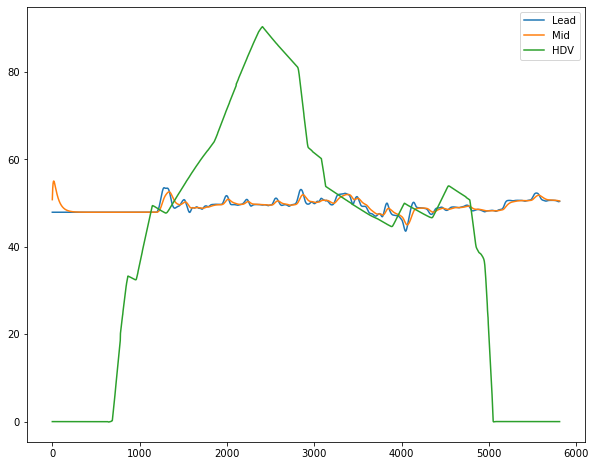

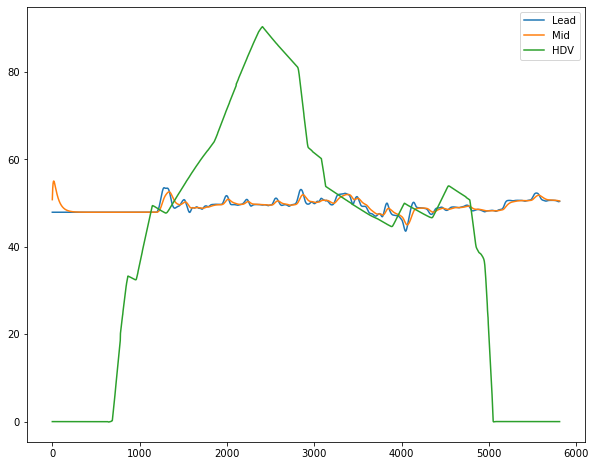

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot((speed[3:step//1,N_lane_0+N_lane_1])/m2m, label='Lead')
plt.plot((speed[3:step//1,N_lane_0+N_lane_1+1])/m2m, label='Mid')
plt.plot(vel_ego[3:step//1]/m2m, label='HDV')
plt.legend()

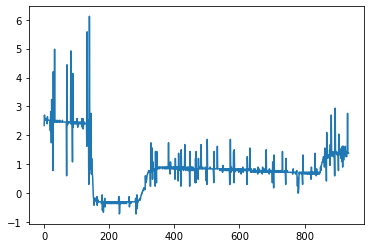

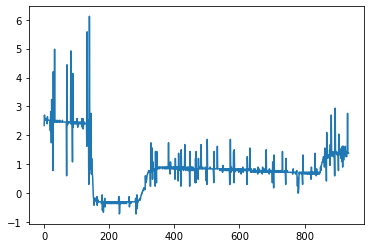

In [8]:
plt.plot(np.diff(vel_ego[1000:step//3])/dt, label='HDV')